# Import

In [1]:
import findspark
findspark.init()
findspark.find()

'd:\\pp_git\\BD_2024\\venv\\lib\\site-packages\\pyspark'

In [2]:
from delta import configure_spark_with_delta_pip

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

from pyspark.ml.fpm import FPGrowth
from pyspark.sql import functions as f
from pyspark.sql import SparkSession
from pyspark.sql.window import Window

from core.csv_data_manager import CSVDataManager
from core.delta_lake_manager import DeltaLakeManager
from core.environment import Environment

from metadata import deltalake
from metadata.columns import StackExchangeColumns as columns

# Session

In [3]:
environment = Environment()

In [4]:
builder = (
    SparkSession.builder
        .master(environment.spark_master())
        .appName(environment.app_name())
        .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
        .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
)
spark_session = configure_spark_with_delta_pip(builder).getOrCreate()
spark_session.sparkContext.setLogLevel("ERROR")

In [5]:
deltalake_manages = DeltaLakeManager(spark_session, environment.data_directory_path(), deltalake.DELTALAKE_NAME)
csv_data_manager = CSVDataManager(spark_session, environment.data_directory_path())

# Load

In [6]:
questions = deltalake_manages.read(deltalake.PROCESSED_QUESTIONS)
answers = deltalake_manages.read(deltalake.PROCESSED_ANSWERS)
comments = deltalake_manages.read(deltalake.PROCESSED_COMMENTS)

In [7]:
questions = questions.withColumn(columns.partition_date, f.to_timestamp(columns.partition_date, 'dd_MM_yyyy'))
answers = answers.withColumn(columns.partition_date, f.to_timestamp(columns.partition_date, 'dd_MM_yyyy'))
comments = comments.withColumn(columns.partition_date, f.to_timestamp(columns.partition_date, 'dd_MM_yyyy'))

# General info

In [44]:
general_info_pd = pd.DataFrame({
    'Category': ["Questions", "Answers", "Comments"],
    'Count': [questions.count(), answers.count(), comments.count()],
})
general_info_df = spark_session.createDataFrame(general_info_pd)

In [46]:
# csv_data_manager.write(general_info_df, "/general_info")

In [45]:
general_info_df.show()

+---------+-----+
| Category|Count|
+---------+-----+
|Questions|18400|
|  Answers|20235|
| Comments|58318|
+---------+-----+



In [54]:
fig = px.bar(
    general_info_df.toPandas(),
    x="Category", y="Count", title="Activity over the time", color="Category")
fig.show(
    config={
        'displayModeBar': False
    }
)

# Assosiation rules

In [55]:
id_tag_df = questions.select(
    columns.id, f.sort_array(columns.tags).alias(columns.tags)
)

In [56]:
fpGrowth = FPGrowth(itemsCol=columns.tags, minSupport=0.01, minConfidence=0.1)
model = fpGrowth.fit(id_tag_df)

In [57]:
model.freqItemsets.show(100, False)

+---------------------+----+
|items                |freq|
+---------------------+----+
|[swift]              |275 |
|[dart]               |209 |
|[dart, flutter]      |203 |
|[typescript]         |504 |
|[sql]                |331 |
|[amazon-web-services]|263 |
|[node.js]            |484 |
|[postgresql]         |237 |
|[reactjs]            |1000|
|[reactjs, javascript]|346 |
|[ios]                |289 |
|[android]            |738 |
|[angular]            |411 |
|[c#]                 |816 |
|[php]                |423 |
|[python-3.x]         |275 |
|[laravel]            |213 |
|[flutter]            |582 |
|[next.js]            |351 |
|[pandas]             |265 |
|[pandas, python]     |214 |
|[c++]                |493 |
|[javascript]         |1518|
|[kotlin]             |241 |
|[django]             |290 |
|[c]                  |250 |
|[r]                  |496 |
|[docker]             |313 |
|[react-native]       |284 |
|[java]               |864 |
|[css]                |468 |
|[css, html]  

In [64]:
top_most_frequent_tags = model.freqItemsets.sort(
    f.desc("freq")
    ).withColumn("items", f.concat_ws("-", f.col("items"))).limit(16)

In [ ]:
# csv_data_manager.write(top_most_frequent_tags, "/top_most_frequent_tags")

In [67]:
fig = px.bar(
    top_most_frequent_tags.toPandas(),
    x="items", y="freq", title="TEst", color="freq")
fig.show(
    config={
        'displayModeBar': False
    }
)

In [72]:
association_rules_df = model.associationRules.withColumn(
    "antecedent", f.concat_ws("-", f.col("antecedent"))
).withColumn(
    "consequent", f.concat_ws("-", f.col("consequent"))
)

In [ ]:
# csv_data_manager.write(association_rules_df, "/association_rules_df")

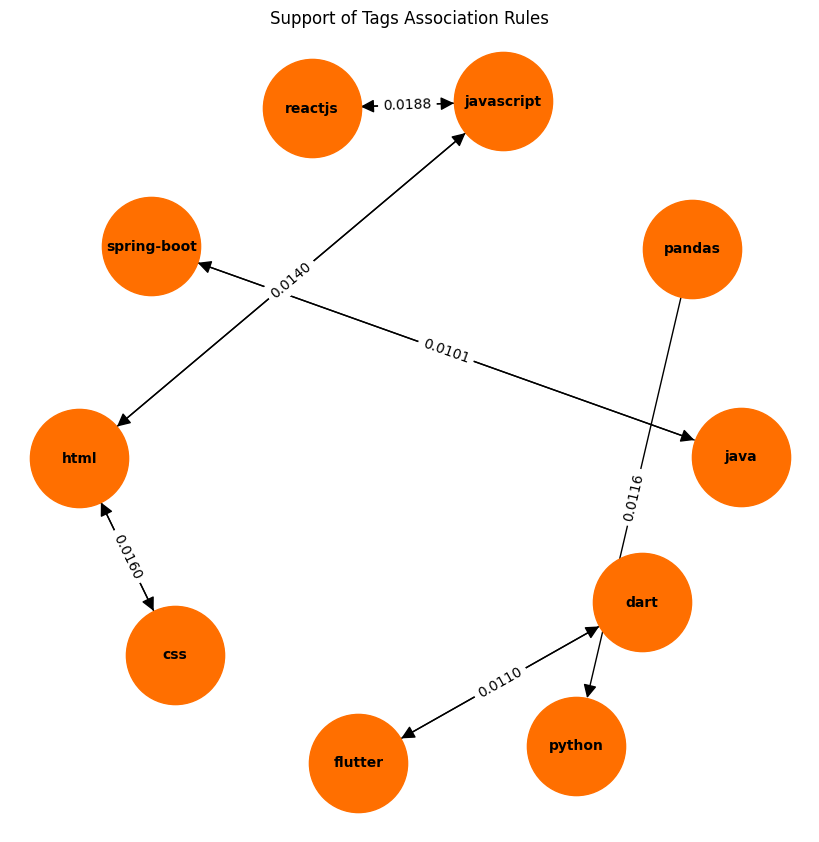

In [76]:
G = nx.DiGraph()

for index, row in association_rules_df.toPandas().iterrows():
    antecedent = row['antecedent']
    consequent = row['consequent']
    # confidence = row['confidence']
    support = row['support']
    
    G.add_edge(antecedent, consequent, weight=support, label=f"{support:.4f}")

plt.figure(figsize=(8, 8))
pos = nx.spring_layout(
    # G, k=0.7
    G, 
    k=0.8,
    seed=24
    )
edges = G.edges(data=True)

nx.draw(
    G, pos, with_labels=True, node_color='#ff6f00', node_size=5000,
    font_size=10, font_color='black', font_weight='bold', arrowsize=20
)

edge_labels = {(u, v): d['label'] for u, v, d in edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

plt.title("Support of Tags Association Rules")
plt.show()


In [75]:
# freqItemsets = model.freqItemsets.sort(f.desc("freq")).limit(16).toPandas()
# items = [str(i) for i in freqItemsets["items"].to_list()]
# freq = freqItemsets["freq"].to_list()

# plt.figure(figsize=(20, 8))
# bars = plt.bar(items, freq, width=0.7, color="#ff6f00")

# for bar in bars:
#     value = bar.get_height()
#     plt.text(
#         bar.get_x() + bar.get_width() / 2,
#         value + 0.5,
#         f'{value}',  # Text to display
#         ha='center',
#         va='bottom'
#     )

# plt.title('Technology Frequency')
# plt.xlabel('Technology stack')
# plt.ylabel('Frequency')
# plt.show()

In [74]:
# G = nx.DiGraph()

# for index, row in model.associationRules.toPandas().iterrows():
#     antecedent = ', '.join(row['antecedent'])
#     consequent = ', '.join(row['consequent'])
#     # confidence = row['confidence']
#     support = row['support']
    
#     G.add_edge(antecedent, consequent, weight=support, label=f"{support:.4f}")

# plt.figure(figsize=(8, 8))
# pos = nx.spring_layout(
#     # G, k=0.7
#     G, 
#     k=0.8,
#     seed=24
#     )
# edges = G.edges(data=True)

# nx.draw(
#     G, pos, with_labels=True, node_color='#ff6f00', node_size=5000,
#     font_size=10, font_color='black', font_weight='bold', arrowsize=20
# )

# edge_labels = {(u, v): d['label'] for u, v, d in edges}
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

# plt.title("Support of Tags Association Rules")
# plt.show()


In [81]:
# G = nx.DiGraph()

# for index, row in model.associationRules.toPandas().iterrows():
#     antecedent = ', '.join(row['antecedent'])
#     consequent = ', '.join(row['consequent'])
#     # confidence = row['confidence']
#     support = row['support']
    
#     G.add_edge(antecedent, consequent, weight=-support, label=f"{support:.4f}")

# plt.figure(figsize=(12, 8))
# pos = nx.spring_layout(G, k=1.0)
# edges = G.edges(data=True)

# nx.draw(
#     G, pos, with_labels=True, node_color='orange', node_size=5000,
#     font_size=10, font_color='black', font_weight='bold', arrowsize=20
# )

# edge_labels = {(u, v): d['label'] for u, v, d in edges}
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

# plt.title("Support of Tags Association Rules")
# plt.show()


# Tags frequecy through time

In [33]:
partitionDataWindow = Window.partitionBy(columns.partition_date).orderBy(f.desc(columns.count))
rank_column = "Rank"

tag_frequency_through_time = questions.select(
        columns.partition_date, f.explode(columns.tags).alias(columns.tag)
    ).withColumn(
        columns.count, f.lit(1)
    ).groupBy(
        columns.partition_date, columns.tag
    ).agg(
        f.sum(columns.count).alias(columns.count)
    ).withColumn(
        rank_column,
        f.row_number().over(partitionDataWindow)
    ).filter(
        f.col(rank_column) <= 7
    ).drop(
        rank_column
    )

In [34]:
most_freq_tags = tag_frequency_through_time.select(f.collect_set(columns.tag)).first()[0]

In [35]:
most_freq_tags

['java',
 'flutter',
 'javascript',
 'c++',
 'html',
 'c#',
 'typescript',
 'python',
 'android',
 'reactjs']

In [11]:
tag_frequency_through_time = questions.select(
        columns.partition_date, f.explode(columns.tags).alias(columns.tag)
    ).withColumn(
        columns.count, f.lit(1)
    ).groupBy(
        columns.partition_date, columns.tag
    ).agg(
        f.sum(columns.count).alias(columns.count)
    ).filter(
        f.col(columns.tag).isin(most_freq_tags)
    ).sort(
        f.col(columns.partition_date), f.col(columns.tag)
    )

In [30]:
# csv_data_manager.write(tag_frequency_through_time, "/tags_frequency")

In [31]:
pd_df = tag_frequency_through_time.toPandas()

In [32]:
import plotly.express as px
fig = px.line(
    pd_df,
    x="PartitionDate",
    y="Count",
    color="Tag",
    title="Tag Counts Over Time",
    markers=True,
)

fig.show()

# Accepted answers analysis

In [8]:
renamed_answers = answers.select(
    f.col(columns.id).alias(columns.answer_id),
    columns.parent_id,
    f.col(columns.owner_user_id).alias(columns.answer_owner_user_id),
    f.col(columns.score).alias(columns.answer_score),
    f.col(columns.wordsCount).alias(columns.answer_words_count),
    f.col(columns.creation_date).alias(columns.answer_creation_date)
)

In [9]:
answers_count = "AnswersCount"

In [10]:
questionIdWindow = Window.partitionBy(columns.id)

questions_with_answers_info = questions.join(
    renamed_answers, 
    questions[columns.accepted_answer_id] == renamed_answers[columns.answer_id],
    "left"
).withColumn(
    columns.self_answered,
    f.col(columns.owner_user_id) == f.col(columns.answer_owner_user_id)
).select(
    columns.id, columns.score, columns.view_count,
    columns.tags, columns.wordsCount,
    columns.creation_date,
    f.col(columns.answer_score).alias("AcceptedAnswerScore"),
    f.col(columns.answer_words_count).alias("AcceptedAnswerWordsCount"),
    columns.answer_creation_date,
    columns.self_answered
).withColumn(
    "AcceptedAnswerAppearenceTimeInHours",
    (f.col(columns.answer_creation_date).cast("long") - f.col(columns.creation_date).cast("long")) / 3600
).drop(
    columns.answer_creation_date
).join(
    renamed_answers, 
    questions[columns.id] == renamed_answers[columns.parent_id],
    "left"
).withColumn(
        columns.count, f.lit(1)
).withColumn(
    answers_count,
    f.sum(columns.count).over(questionIdWindow)
).withColumn(
    answers_count, 
    f.when(f.col(columns.answer_id).isNull(), 0).otherwise(f.col(answers_count))
).withColumn(
    "AverageAnswerWordsCount",
    f.avg(columns.answer_words_count).over(questionIdWindow)
).drop(
    # columns.answer_id,
    columns.answer_score,
    columns.count,
    columns.parent_id,
    columns.answer_owner_user_id,
    columns.answer_words_count,
    columns.answer_creation_date
).dropDuplicates(
    [columns.id]
)


In [11]:
questions_with_answers_info.show()

+--------+-----+---------+--------------------+----------+-------------------+-------------------+------------------------+------------+-----------------------------------+--------+------------+-----------------------+
|      Id|Score|ViewCount|                Tags|WordsCount|       CreationDate|AcceptedAnswerScore|AcceptedAnswerWordsCount|SelfAnswered|AcceptedAnswerAppearenceTimeInHours|AnswerId|AnswersCount|AverageAnswerWordsCount|
+--------+-----+---------+--------------------+----------+-------------------+-------------------+------------------------+------------+-----------------------------------+--------+------------+-----------------------+
|77740646|    1|      246|[pdf-generation, ...|       386|2024-01-01 02:01:14|                  1|                     369|       false|                  2.468611111111111|77740817|           1|                  369.0|
|77740652|    0|      128|     [extract, 7zip]|        76|2024-01-01 02:04:07|                  0|                      82| 

In [86]:
# import matplotlib.pyplot as plt

# # Data
# labels = ['0', '1', '2', '> 2']
# sizes = [9130, 7356, 1535, 379]
# colors = ['#8a7dc7', '#00689c', '#ffc800', '#ff6f00'][::-1]
# # explode = (0.05, 0, 0, 0)  # Slightly explode Electronics

# # Plot Pie Chart
# plt.figure(figsize=(10, 10))
# # autopct='%1.1f%%', 
# wedges, texts, autotexts = plt.pie(
#     sizes, labels=None, colors=colors, autopct='%1.f%%', startangle=90, shadow=False,
#     wedgeprops={'edgecolor': 'black'}
# )
# plt.legend(wedges, labels, title="number of answers", loc="upper left", fontsize=12)

# for autotext in autotexts[:-1]:
#     autotext.set_fontsize(22)
#     autotext.set_fontname("sans-serif")
# autotexts[-1].set_fontsize(0)
# autotexts[-1].set_fontname("sans-serif")

# for autotext in texts:
#     autotext.set_fontsize(12)
#     autotext.set_fontname("sans-serif")

# plt.title('Number of answers per question')
# plt.show()

In [219]:
# questions_with_answers_info.withColumn(
#     columns.tag,
#     f.explode(f.col(columns.tags))
# ).drop(
#     columns.tags
# ).withColumn(
#     "AcceptedAnswerCount",
#     f.when(f.col("AcceptedAnswerScore").isNull(), 0).otherwise(1)
# ).withColumn(
#     "SelfAnswered",
#     f.when(f.col("SelfAnswered").isNull(), False).otherwise(f.col("SelfAnswered"))
# ).show()

In [11]:
renamed_comments = comments.select(
    f.col(columns.id).alias("CommentId"),
    columns.post_id,
    f.col(columns.wordsCount).alias("CommentWordsCount"),
    f.col(columns.sentiment).alias("CommentSentiment")
).withColumn(
    "Count", f.lit(1)
)

In [12]:
questionIdWindow = Window.partitionBy(columns.id)

questions_with_answers_and_comments_info = questions_with_answers_info.join(
    renamed_comments,
    questions_with_answers_info[columns.id] == renamed_comments[columns.post_id],
    "left"
).withColumn(
    "CommentsCount",
    f.sum(f.col(columns.count)).over(questionIdWindow)
).withColumn(
    "CommentsCount", 
    f.when(f.col("CommentsCount").isNull(), 0).otherwise(f.col("CommentsCount"))
).withColumn(
    "PositiveCommentsCount",
    f.sum(f.col("CommentSentiment")).over(questionIdWindow)
).withColumn(
    "PositiveCommentsCount", 
    f.when(f.col("PositiveCommentsCount").isNull(), 0).otherwise(f.col("PositiveCommentsCount"))
).withColumn(
    "AvgCommentWordsCount",
    f.avg(f.col("CommentWordsCount")).over(questionIdWindow)
).drop(
    "CommentId", columns.post_id, "CommentWordsCount", "CommentSentiment", "Count"
).dropDuplicates(
    [columns.id]
)

In [ ]:
# renamed_answers = answers.select(
#     f.col(columns.id).alias(columns.answer_id),
#     columns.parent_id,
#     f.col(columns.owner_user_id).alias(columns.answer_owner_user_id),
#     f.col(columns.score).alias(columns.answer_score),
#     f.col(columns.wordsCount).alias(columns.answer_words_count),
#     f.col(columns.creation_date).alias(columns.answer_creation_date)
# )

In [14]:
# questions_with_answers_and_comments_info.withColumn(
#     columns.tag,
#     f.explode(f.col(columns.tags))
# ).drop(
#     columns.tags
# ).withColumn(
#     "Count", f.lit(1)
# ).withColumn(
#     "AcceptedAnswerCount",
#     f.when(f.col("AcceptedAnswerScore").isNull(), 0).otherwise(1)
# ).withColumn(
#     "SelfAnswered",
#     f.when(f.col("SelfAnswered").isNull(), False).otherwise(f.col("SelfAnswered"))
# ).show()

In [19]:
final_df = questions_with_answers_and_comments_info.withColumn(
    columns.tag,
    f.explode(f.col(columns.tags))
).drop(
    columns.tags
).withColumn(
    "Count", f.lit(1)
).withColumn(
    "AcceptedAnswerCount",
    f.when(f.col("AcceptedAnswerScore").isNull(), 0).otherwise(1)
).withColumn(
    "SelfAnswered",
    f.when(f.col("SelfAnswered").isNull(), False).otherwise(f.col("SelfAnswered"))
).groupBy(
    columns.tag
).agg(
    f.sum(f.col("Count")).alias("QuestionsCount"),
    f.sum(f.col("AnswersCount")).alias("SumAnswersCount"),
    f.sum(f.col("AcceptedAnswerCount")).alias("SumAcceptedAnswerCount"),
    f.sum(f.col("SelfAnswered").cast("int")).alias("SumSelfAnswered"),
    f.avg(f.col("AnswersCount")).alias("AnswersPerQuestions"),
    f.avg(f.col("AcceptedAnswerCount")).alias("AcceptedAnswersPerQuestions"),
    f.avg(f.col("SelfAnswered").cast("int")).alias("SelfAnsweredPerQuestions"),
    f.avg(f.col("AcceptedAnswerAppearenceTimeInHours")).alias("AvgAcceptedAnswerAppearenceTimeInHours"),
    # f.avg(f.col(columns.score)).alias("AvgQuestionScore"),
    f.avg(f.col(columns.view_count)).alias("AvgQuestionViewCount"),
    f.avg(f.col(columns.wordsCount)).alias("AvgQuestionWordsCount"),
    # f.avg(f.col("AcceptedAnswerScore")).alias("AvgAcceptedAnswerScore"),
    f.avg(f.col("AverageAnswerWordsCount")).alias("AvgAnswerWordsCount"),
    f.avg(f.col("AcceptedAnswerWordsCount")).alias("AvgAcceptedAnswerWordsCount"),
    f.avg(f.col("CommentsCount")).alias("CommentsCountPerQuestion"),
    f.avg(f.col("PositiveCommentsCount")).alias("PositiveCommentsPerQuestion"),
    f.avg(f.col("AvgCommentWordsCount")).alias("AvgCommentWordsCount_"),
    f.sum(f.col("CommentsCount")).alias("SumCommentsCount"),
    f.sum(f.col("PositiveCommentsCount")).alias("SumPositiveComments"),
).withColumn(
    "PortionsOfPositiveComments",
    f.when(f.col("SumCommentsCount") != 0, f.col("SumPositiveComments") / f.col("SumCommentsCount")).otherwise(0)
).withColumn(
    "PortionsOfAnswered",
    f.when(f.col("QuestionsCount") != 0, f.col("SumAcceptedAnswerCount") / f.col("QuestionsCount")).otherwise(0)
).withColumn(
    "SumSelfAnswered",
    f.when(f.col("SumSelfAnswered").isNull(), 0).otherwise(f.col("SumSelfAnswered"))
).withColumn(
    "AvgAnswerWordsCount",
    f.when(f.col("AvgAnswerWordsCount").isNull(), 0).otherwise(f.col("AvgAnswerWordsCount"))
).withColumn(
    "AvgAcceptedAnswerAppearenceTimeInHours",
    f.when(f.col("AvgAcceptedAnswerAppearenceTimeInHours").isNull(), float("inf")).otherwise(f.col("AvgAcceptedAnswerAppearenceTimeInHours"))
).sort(
    f.desc("QuestionsCount")
)

In [20]:
final_df.show()

+-----------+--------------+---------------+----------------------+---------------+-------------------+---------------------------+------------------------+--------------------------------------+--------------------+---------------------+-------------------+---------------------------+------------------------+---------------------------+---------------------+----------------+-------------------+--------------------------+-------------------+
|        Tag|QuestionsCount|SumAnswersCount|SumAcceptedAnswerCount|SumSelfAnswered|AnswersPerQuestions|AcceptedAnswersPerQuestions|SelfAnsweredPerQuestions|AvgAcceptedAnswerAppearenceTimeInHours|AvgQuestionViewCount|AvgQuestionWordsCount|AvgAnswerWordsCount|AvgAcceptedAnswerWordsCount|CommentsCountPerQuestion|PositiveCommentsPerQuestion|AvgCommentWordsCount_|SumCommentsCount|SumPositiveComments|PortionsOfPositiveComments| PortionsOfAnswered|
+-----------+--------------+---------------+----------------------+---------------+-------------------+-----

In [21]:
csv_data_manager.write(final_df, "/final_df")

In [22]:
final_df.count()

9515

In [ ]:
1 / 0

In [16]:
# # tagWindow = Window.partitionBy(columns.tag)
# questions_with_answers_info.withColumn(
#     columns.tag,
#     f.explode(f.col(columns.tags))
# ).drop(
#     columns.tags
# ).withColumn(
#     "Count", f.lit(1)
# ).withColumn(
#     "AcceptedAnswerCount",
#     f.when(f.col("AcceptedAnswerScore").isNull(), 0).otherwise(1)
# ).withColumn(
#     "SelfAnswered",
#     f.when(f.col("SelfAnswered").isNull(), False).otherwise(f.col("SelfAnswered"))
# ).groupBy(
#     columns.tag
# ).agg(
#     f.sum(f.col("Count")).alias("QuestionsCount"),
#     f.sum(f.col("AnswersCount")).alias("SumAnswersCount"),
#     f.sum(f.col("AcceptedAnswerCount")).alias("SumAcceptedAnswerCount"),
#     f.sum(f.col("SelfAnswered").cast("int")).alias("SumSelfAnswered"),
#     f.avg(f.col("AnswersCount")).alias("AnswersPerQuestions"),
#     f.avg(f.col("AcceptedAnswerCount")).alias("AcceptedAnswersPerQuestions"),
#     f.avg(f.col("SelfAnswered").cast("int")).alias("SelfAnsweredPerQuestions"),
#     f.avg(f.col("AcceptedAnswerAppearenceTimeInHours")).alias("AvgAcceptedAnswerAppearenceTimeInHours"),
#     # f.avg(f.col(columns.score)).alias("AvgQuestionScore"),
#     f.avg(f.col(columns.view_count)).alias("AvgQuestionViewCount"),
#     f.avg(f.col(columns.wordsCount)).alias("AvgQuestionWordsCount"),
#     # f.avg(f.col("AcceptedAnswerScore")).alias("AvgAcceptedAnswerScore"),
#     f.avg(f.col("AverageAnswerWordsCount")).alias("AvgAnswerWordsCount"),
#     f.avg(f.col("AcceptedAnswerWordsCount")).alias("AvgAcceptedAnswerWordsCount"),
# ).withColumn(
#     "SumSelfAnswered",
#     f.when(f.col("SumSelfAnswered").isNull(), 0).otherwise(f.col("SumSelfAnswered"))
# ).withColumn(
#     "AvgAnswerWordsCount",
#     f.when(f.col("AvgAnswerWordsCount").isNull(), 0).otherwise(f.col("AvgAnswerWordsCount"))
# ).withColumn(
#     "AvgAcceptedAnswerAppearenceTimeInHours",
#     f.when(f.col("AvgAcceptedAnswerAppearenceTimeInHours").isNull(), float("inf")).otherwise(f.col("AvgAcceptedAnswerAppearenceTimeInHours"))
# ).sort(
#     f.desc("QuestionsCount")
# ).show(30)

In [218]:
# questions_with_answers_info.withColumn(
#     columns.tag,
#     f.explode(f.col(columns.tags))
# ).drop(
#     columns.tags
# ).groupBy(
#     columns.tag
# ).agg(
#     f.avg(f.col(columns.score)).alias("AverageQuestionScore"),
#     f.avg(f.col(columns.view_count)).alias("AverageQuestionViewCount"),
#     # f.avg(f.col("AcceptedAnswerScore")).alias("AverageAcceptedAnswerScore"),
#     f.avg(f.col("AcceptedAnswerWordsCount")).alias("AverageAcceptedAnswerWordsCount"),
# ).show()